# SciPy
![SciPy](https://raw.githubusercontent.com/scipy/scipy-sphinx-theme/master/_static/scipyshiny_small.png)

- Uses numpy as its core
- Numerical methods for 
    - integration
    - solving differential equations
    - optimizing, minimizing 
    - root finding
    - fast fourier transforms
    
- Contains the CODATA values for many constants of nature
- Mostly build as wrappers around time-proven fortran libraries (fftpack, lapack, fitpack)

In [4]:
import scipy as sp

# we will need to plot stuff later
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

## Physical constants

In [5]:
import scipy.constants as const
const.epsilon_0

8.854187817620389e-12

In [6]:
# convert temperatures:
const.convert_temperature(100, old_scale='C', new_scale='K')

373.14999999999998

In [7]:
# more constants (including units and errors)!
for k, v in const.physical_constants.items():
    print(k, ':', v)

Wien displacement law constant : (0.0028977685, 'm K', 5.1e-09)
atomic unit of 1st hyperpolarizablity : (3.20636151e-53, 'C^3 m^3 J^-2', 2.8e-60)
atomic unit of 2nd hyperpolarizablity : (6.2353808e-65, 'C^4 m^4 J^-3', 1.1e-71)
atomic unit of electric dipole moment : (8.47835309e-30, 'C m', 7.3e-37)
atomic unit of electric polarizablity : (1.648777274e-41, 'C^2 m^2 J^-1', 1.6e-49)
atomic unit of electric quadrupole moment : (4.48655124e-40, 'C m^2', 3.9e-47)
atomic unit of magn. dipole moment : (1.8548019e-23, 'J T^-1', 1.6e-30)
atomic unit of magn. flux density : (235051.755, 'T', 0.0014)
deuteron magn. moment : (4.33073482e-27, 'J T^-1', 3.8e-34)
deuteron magn. moment to Bohr magneton ratio : (0.0004669754567, '', 5e-12)
deuteron magn. moment to nuclear magneton ratio : (0.8574382329, '', 9.2e-09)
deuteron-electron magn. moment ratio : (-0.0004664345548, '', 5e-12)
deuteron-proton magn. moment ratio : (0.3070122084, '', 4.5e-09)
deuteron-neutron magn. moment ratio : (-0.44820652, '', 

In [8]:
val, unit, uncertainty = const.physical_constants['muon mass energy equivalent in MeV']

val, unit, uncertainty

(105.6583745, 'MeV', 2.4e-06)

# Fitting

### curve_fit

least-squares with Levenberg-Marquardt numerical minimization

In [28]:
from scipy.optimize import curve_fit

a = -1
b = 5

x = np.linspace(0, 5, 100)
y = np.exp(a * x) + b + np.random.normal(0, 0.1, 100)


def f(x, a, b):
    return np.exp(a * x) + b


params, covariance_matrix = curve_fit(f, x, y)

uncertainties = np.sqrt(np.diag(covariance_matrix))

print('a = {:5.2f} ± {:.2f}'.format(params[0], uncertainties[0]))
print('b = {:5.2f} ± {:.2f}'.format(params[1], uncertainties[1]))

a = -0.96 ± 0.08
b =  5.00 ± 0.02


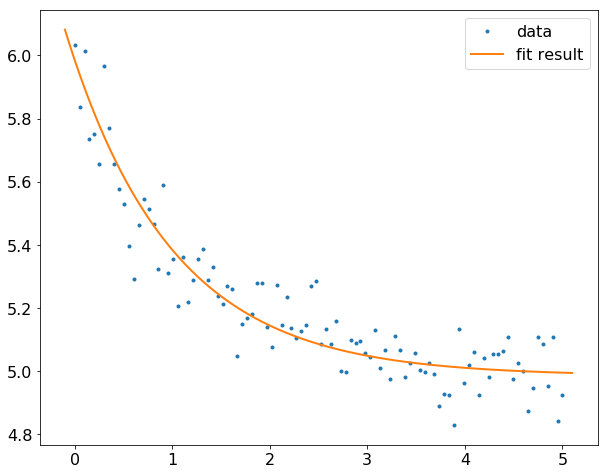

In [20]:
x_plot = np.linspace(-0.1, 5.1, 1000)

plt.plot(x, y, '.', label='data')
plt.plot(x_plot, f(x_plot, *params), label='fit result')
plt.legend()

## Providing uncertainties and initial guesses

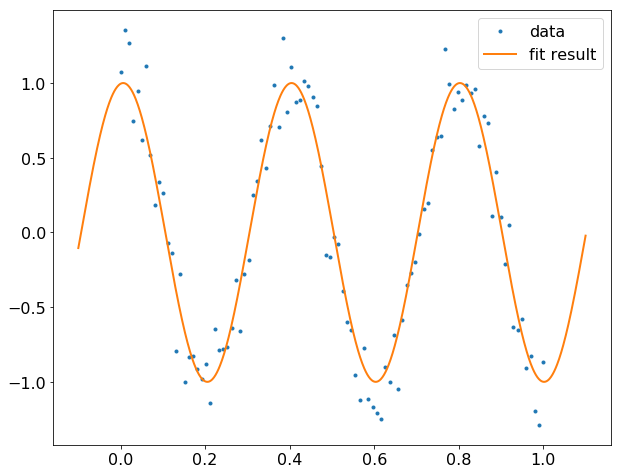

In [56]:
x = np.linspace(0, 1, 100)
y = np.sin(5 * np.pi * x + np.pi / 2) 
yerr = np.full_like(y, 0.2)

noise = np.random.normal(0, yerr, 100)

y += noise

def f(x, a, b):
    return np.sin(a * x + b)


#params, covariance_matrix = curve_fit(f, x, y)

#params, covariance_matrix = curve_fit(
#    f, x, y,
#    p0=[12, 1],
#)

params, covariance_matrix = curve_fit(
    f, x, y,
    p0=[15, 1.5],
    sigma=yerr,
    absolute_sigma=True,
)


# plot the stuff

x_plot = np.linspace(-0.1, 1.1, 1000)

plt.plot(x, y, '.', label='data')
plt.plot(x_plot, f(x_plot, *params), label='fit result')
plt.legend()

### Plot the correlation maxtrix

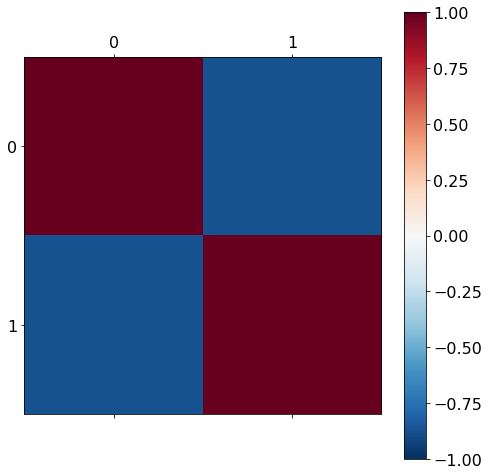

In [63]:
D = np.diag(1 / np.sqrt(np.diag(covariance_matrix)))

correlation_matrix = D @ covariance_matrix @ D


plt.matshow(correlation_matrix, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

## Unbinned likelihood fits using scipy.minize

Simple example: an unbinned negative log-likelihood fit for a poissonian distribution

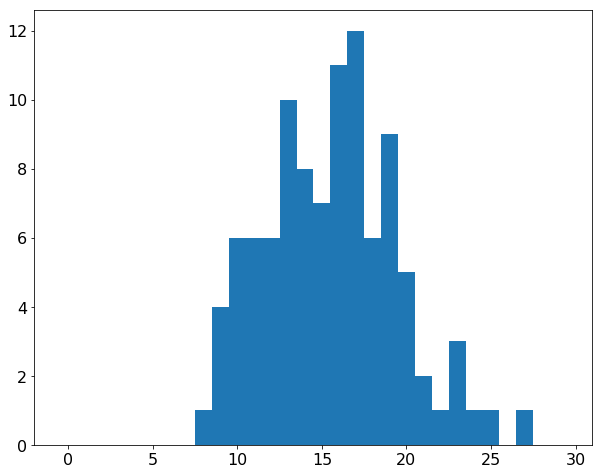

In [43]:
lambda_ = 15
k = np.random.poisson(lambda_, 100)

# make sure to use bins of integer width, centered around the integer
bin_edges = np.arange(0, 31) - 0.5

plt.hist(k, bins=bin_edges)
None

Poisson pdf:

$$ 
f(k, \lambda) = \frac{\lambda^k}{k!} \mathrm{e}^{-\lambda}
$$

So the likelihood is:

$$
\mathcal{L} = \prod_{i=0}^{N} \frac{\lambda^{k_i}}{k_i!} \mathrm{e}^{-\lambda}
$$

It's often easier to minimize $-\log(\mathcal{L})$, let's see:

$$
-\log(\mathcal{L}) = - \sum_{i=0}^{N}\bigl( k_i \log(\lambda) - \log{k_i!} - \lambda \bigr)
$$

We are interested in the minimum reletive to $\lambda$, so we dismiss constant term concerning $\lambda$ 
$$
-\log(\mathcal{L}) = \sum_{i=0}^{N}\bigl( \lambda - k_i \log(\lambda) \bigr)   
$$

This looks indeed easier to minimize than the likelihood.

In [44]:
from scipy.optimize import minimize


def negative_log_likelihood(lambda_, k):
    return np.sum(lambda_ - k * np.log(lambda_))


result = minimize(
    negative_log_likelihood,
    x0=(10, ),   # initial guess
    args=(k, ),  # additional arguments for the function to minimize
)

print(result)

      fun: -2717.5036999620766
 hess_inv: array([[ 0.1553816]])
      jac: array([ 0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([ 15.57000041])


* minimize has lots of options for different minimization algorithms
* Also able to respect bounds and constraints (with certain algorithms)
* It is worth to write down you problems and simplify the (log)Likelihood as much as possible

## A more complicated example

Fitting a gaussian with an exponential background 

Let's say we have two distributions, an exponential and a gaussian:

$$
f(x, \mu, \sigma, \tau, p) =  p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x / \tau}
$$

Likelihood:
$$
\mathcal{L} = \prod_{i = 0}^N \bigl( p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x_i / \tau} \bigr)
$$
Negative log-likelihood:

$$
-\log(\mathcal{L}) = -\sum_{i = 0}^N \log\bigl( p \cdot \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}} + (1 - p) \cdot \frac{1}{\tau} \mathrm{e}^{- x_i / \tau} \bigr)
$$

But we can make use of the built in scipy distributions:

      fun: 16741.208586528042
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0003638 ,  0.0003638 ,  0.0003638 ,  0.00291038])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 27
   status: 0
  success: True
        x: array([ 15.2127959 ,   1.50046682,  10.28003893,   0.08063453])


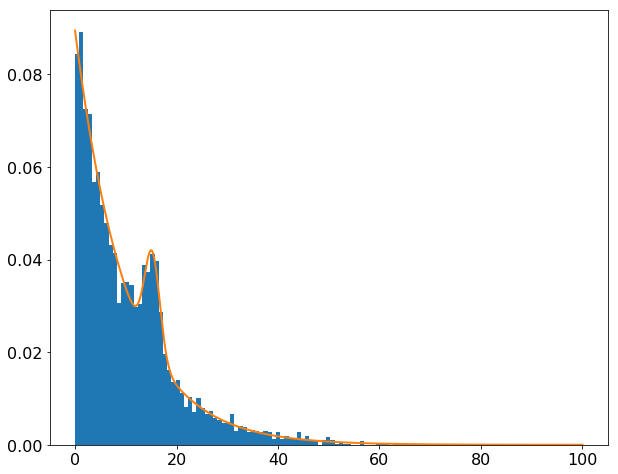

In [104]:
from scipy.stats import norm, expon

x = np.append(
    norm.rvs(loc=15, scale=2, size=500), 
    expon.rvs(scale=10, size=4500),
)

def pdf(x, mu, sigma, tau, p):
    return p * norm.pdf(x, mu, sigma) + (1 - p) * expon.pdf(x, scale=tau)


def negative_log_likelihood(params, x):
    mu, sigma, tau, p = params
    neg_l = -np.sum(np.log(pdf(x, mu, sigma, tau, p)))

    return neg_l


result = minimize(
    negative_log_likelihood,
    x0=(12, 1.5, 8, 0.2),   # initial guess
    args=(x, ),            # additional arguments for the function to minimize
    bounds=[
        (None, None),      # no bounds for mu
        (0, None),         # sigma >= 0
        (0, None),         # tau >= 0
        (0, 1),            # 0 <= p <= 1
    ],
    method='L-BFGS-B', # method that supports bounds
)

x_plot = np.linspace(0, 100, 1000)

plt.hist(x, bins=100, normed=True)
plt.plot(x_plot, pdf(x_plot, *result.x))

print(result)

In [ ]:
x = expon.rvs

## FFTs

In [136]:
freq1 = 5
freq2 = 50

t = np.linspace(0, 1, 1024 * 10)
y = np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t)

# add some white noise
y += np.random.normal(y, 5)

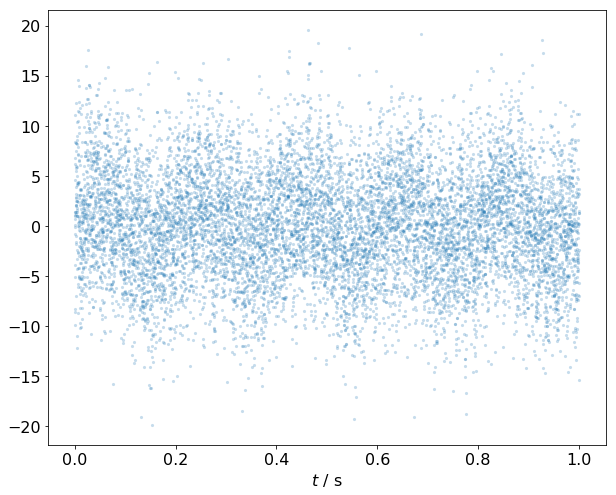

In [137]:
plt.scatter(t, y, s=10, alpha=0.25, lw=0)
plt.xlabel(r'$t \ /\ \mathrm{s}$')

In [138]:
from scipy import fftpack

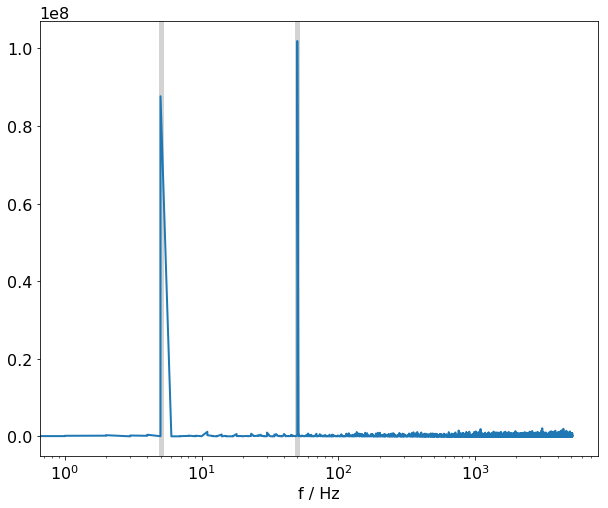

In [145]:
z = fftpack.rfft(y)
f = fftpack.rfftfreq(len(t), t[1] - t[0])

plt.axvline(freq1, color='lightgray', lw=5)
plt.axvline(freq2, color='lightgray', lw=5)

plt.plot(f, np.abs(z)**2)

plt.xlabel('f / Hz')
plt.xscale('log')
# plt.yscale('log')